In [1]:
import sys
sys.path

['/Users/mz/Projects/rf',
 '/Users/mz/.vscode/extensions/ms-toolsai.jupyter-2021.2.576440691/pythonFiles',
 '/Users/mz/.vscode/extensions/ms-toolsai.jupyter-2021.2.576440691/pythonFiles/lib/python',
 '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python38.zip',
 '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8',
 '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/lib-dynload',
 '',
 '/Users/mz/Projects/rf/.venv/lib/python3.8/site-packages',
 '/Users/mz/Projects/rf/.venv/lib/python3.8/site-packages/IPython/extensions',
 '/Users/mz/.ipython']

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 

from gym import wrappers


In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

%matplotlib inline


In [4]:
class DQN(nn.Module):
    def __init__(self, image_height, image_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features=image_height*image_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=2)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
) # create a namedtuple sub class named Experience

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size



In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)    

In [8]:
class Agent:
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit


In [9]:
class EnvManager:
    def __init__(self, device, gym_make = 'CartPole-v0'):
        self.device = device
        self.env = gym.make(gym_make).unwrapped
        self.env = wrappers.Monitor(self.env, "./temp", video_callable=False ,force=True)

        self.reset()
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        observation, reward, self.done, info = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def get_state0(self):
        if self.current_screen is None or self.done:
            self.current_screen = self.get_processed_screen()
            return torch.zeros_like(self.current_screen) # all black screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            screen_change = s2-s1
            print("sds")
            self.current_screen = s2
            return screen_change

    def get_state(self):
        if self.current_screen is None or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (B-C-H-W)

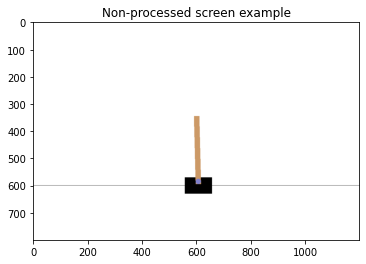

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = EnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()


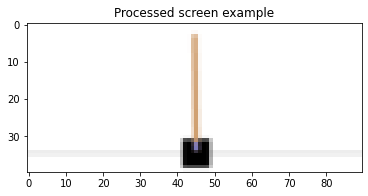

In [11]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

In [12]:
print(screen.shape)
print(screen.squeeze(0).shape) # remove a 
print(em.env.render('rgb_array').shape)
print(em.env.render('rgb_array').transpose((2, 0, 1)).shape)
print(type(em.env.render('rgb_array')))

torch.Size([1, 3, 40, 90])
torch.Size([3, 40, 90])
(800, 1200, 3)
(3, 800, 1200)
<class 'numpy.ndarray'>


tensor(True)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


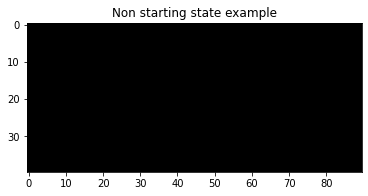

In [13]:
em = EnvManager(device)
em.reset()

for i in range(9):
    em.take_action(torch.tensor([1]))
    screen = em.get_state()
    print(torch.all(screen==0))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

In [14]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)

In [15]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

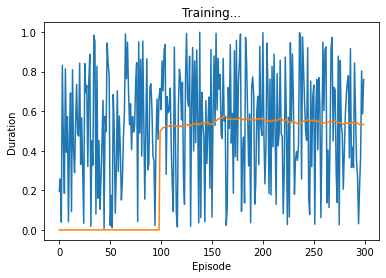

In [16]:
plot(np.random.rand(300), 100)

# Training

In [17]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
em = EnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [20]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [21]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [22]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)


In [23]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [24]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

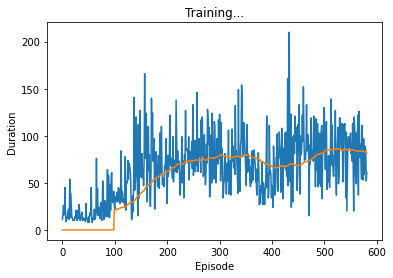

In [25]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()
